In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import json
import h5py
import os
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    import cv2
except:
    pass

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
                            BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pickle

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns


from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
all_images_list = []
for i in os.listdir('stuart_contrib/album_images_(cleaned)'):
    im = cv2.imread('stuart_contrib/album_images_(cleaned)'+'/'+i)
    im = cv2.resize(im,(64,64))
    all_images_list.append(np.array(im)/255.)
all_images_list = np.array(all_images_list)

print('All images now imported.')
print(all_images_list.shape)

All images now imported.
(10156, 64, 64, 3)


# Straight Autoencoder

In [3]:
def get_autoencoder():
    input_img = Input(shape=(64, 64, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    x = Conv2D(16, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [4]:
batch_size = 32
num_classes = 10
epochs = 50
x_train = all_images_list

autoencoder = get_autoencoder()
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/50
10156/10156 [==============================] - 10s 1ms/step - loss: 0.5153
Epoch 2/50
10156/10156 [==============================] - 6s 616us/step - loss: 0.4841
Epoch 3/50
10156/10156 [==============================] - 6s 617us/step - loss: 0.4742
Epoch 4/50
10156/10156 [==============================] - 6s 616us/step - loss: 0.4694
Epoch 5/50
10156/10156 [==============================] - 6s 616us/step - loss: 0.4655
Epoch 6/50
10156/10156 [==============================] - 6s 618us/step - loss: 0.4638
Epoch 7/50
10156/10156 [==============================] - 6s 618us/step - loss: 0.4622
Epoch 8/50
10156/10156 [==============================] - 6s 618us/step - loss: 0.4608
Epoch 9/50
10156/10156 [==============================] - 6s 618us/step - loss: 0.4600
Epoch 10/50
10156/10156 [==============================] - 6s 617us/step - loss: 0.4590
Epoch 11/50
10156/10156 [==============================] - 6s 618us/step - loss: 0.4580
Epoch 12/50
10156/10156 [=================

In [5]:
autoencoder.save('records_ae_small_v1.h5')

# Variational Autoencoder

In [6]:
def sampling(args):
     """Reparameterization trick by sampling fr an isotropic unit Gaussian.
     # Arguments:
         args (tensor): mean and log of variance of Q(z|X)
     # Returns:
         z (tensor): sampled latent vector
     """

     z_mean, z_log_var = args
     batch = K.shape(z_mean)[0]
     dim = K.int_shape(z_mean)[1]
     # by default, random_normal has mean=0 and std=1.0
     epsilon = K.random_normal(shape=(batch, dim))
     return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
image_size = 64
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 50
epochs = 400

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 16384)        0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [8]:
vae.compile(optimizer='rmsprop',loss='binary_crossentropy')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  283252    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 3)         891843    
Total params: 1,175,095
Trainable params: 1,175,095
Non-trainable params: 0
_________________________________________________________________


In [9]:
vae.fit(x_train,x_train,epochs=400)

Epoch 1/400
10156/10156 [==============================] - 5s 522us/step - loss: 0.5991
Epoch 2/400
10156/10156 [==============================] - 4s 408us/step - loss: 0.5561
Epoch 3/400
10156/10156 [==============================] - 4s 410us/step - loss: 0.5481
Epoch 4/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5432
Epoch 5/400
10156/10156 [==============================] - 4s 411us/step - loss: 0.5355
Epoch 6/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5321
Epoch 7/400
10156/10156 [==============================] - 4s 411us/step - loss: 0.5306
Epoch 8/400
10156/10156 [==============================] - 4s 410us/step - loss: 0.5295
Epoch 9/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5283
Epoch 10/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5277
Epoch 11/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5270
Epoch 12/400
10156/10156 [====

10156/10156 [==============================] - 4s 410us/step - loss: 0.5105
Epoch 94/400
10156/10156 [==============================] - 4s 410us/step - loss: 0.5102
Epoch 95/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5099
Epoch 96/400
10156/10156 [==============================] - 4s 410us/step - loss: 0.5098
Epoch 97/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5096
Epoch 98/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5095
Epoch 99/400
10156/10156 [==============================] - 4s 410us/step - loss: 0.5093
Epoch 100/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5093
Epoch 101/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5091
Epoch 102/400
10156/10156 [==============================] - 4s 409us/step - loss: 0.5091
Epoch 103/400
10156/10156 [==============================] - 4s 408us/step - loss: 0.5089
Epoch 104/400
10156/10156 [===

10156/10156 [==============================] - 4s 426us/step - loss: 0.5051
Epoch 185/400
10156/10156 [==============================] - 4s 426us/step - loss: 0.5052
Epoch 186/400
10156/10156 [==============================] - 4s 425us/step - loss: 0.5051
Epoch 187/400
10156/10156 [==============================] - 4s 427us/step - loss: 0.5051
Epoch 188/400
10156/10156 [==============================] - 4s 425us/step - loss: 0.5050
Epoch 189/400
10156/10156 [==============================] - 4s 428us/step - loss: 0.5050
Epoch 190/400
10156/10156 [==============================] - 4s 424us/step - loss: 0.5050
Epoch 191/400
10156/10156 [==============================] - 4s 427us/step - loss: 0.5049
Epoch 192/400
10156/10156 [==============================] - 4s 424us/step - loss: 0.5050
Epoch 193/400
10156/10156 [==============================] - 4s 427us/step - loss: 0.5049
Epoch 194/400
10156/10156 [==============================] - 4s 425us/step - loss: 0.5049
Epoch 195/400
10156/1015

10156/10156 [==============================] - 4s 424us/step - loss: 0.5034
Epoch 276/400
10156/10156 [==============================] - 16s 2ms/step - loss: 0.5033
Epoch 277/400
10156/10156 [==============================] - 5s 462us/step - loss: 0.5034
Epoch 278/400
10156/10156 [==============================] - 5s 463us/step - loss: 0.5033
Epoch 279/400
10156/10156 [==============================] - 5s 472us/step - loss: 0.5033
Epoch 280/400
10156/10156 [==============================] - 5s 466us/step - loss: 0.5033
Epoch 281/400
10156/10156 [==============================] - 5s 468us/step - loss: 0.5032
Epoch 282/400
10156/10156 [==============================] - 5s 453us/step - loss: 0.5032
Epoch 283/400
10156/10156 [==============================] - 5s 458us/step - loss: 0.5032
Epoch 284/400
10156/10156 [==============================] - 5s 460us/step - loss: 0.5033
Epoch 285/400
10156/10156 [==============================] - 5s 461us/step - loss: 0.5032
Epoch 286/400
10156/10156

KeyboardInterrupt: 

In [10]:
vae.save('records_vae_small_v1.h5')
encoder.save('records_small_encoder_v1.h5')
decoder.save('records_small_decoder_v1.h5')

# Investigate our results...

In [11]:
vae = load_model('records_vae_small_v1.h5')
ae = load_model('records_ae_small_v1.h5')

(64, 64, 3)
(10, 64, 64, 3)
   Original ===  AE ===  VAE


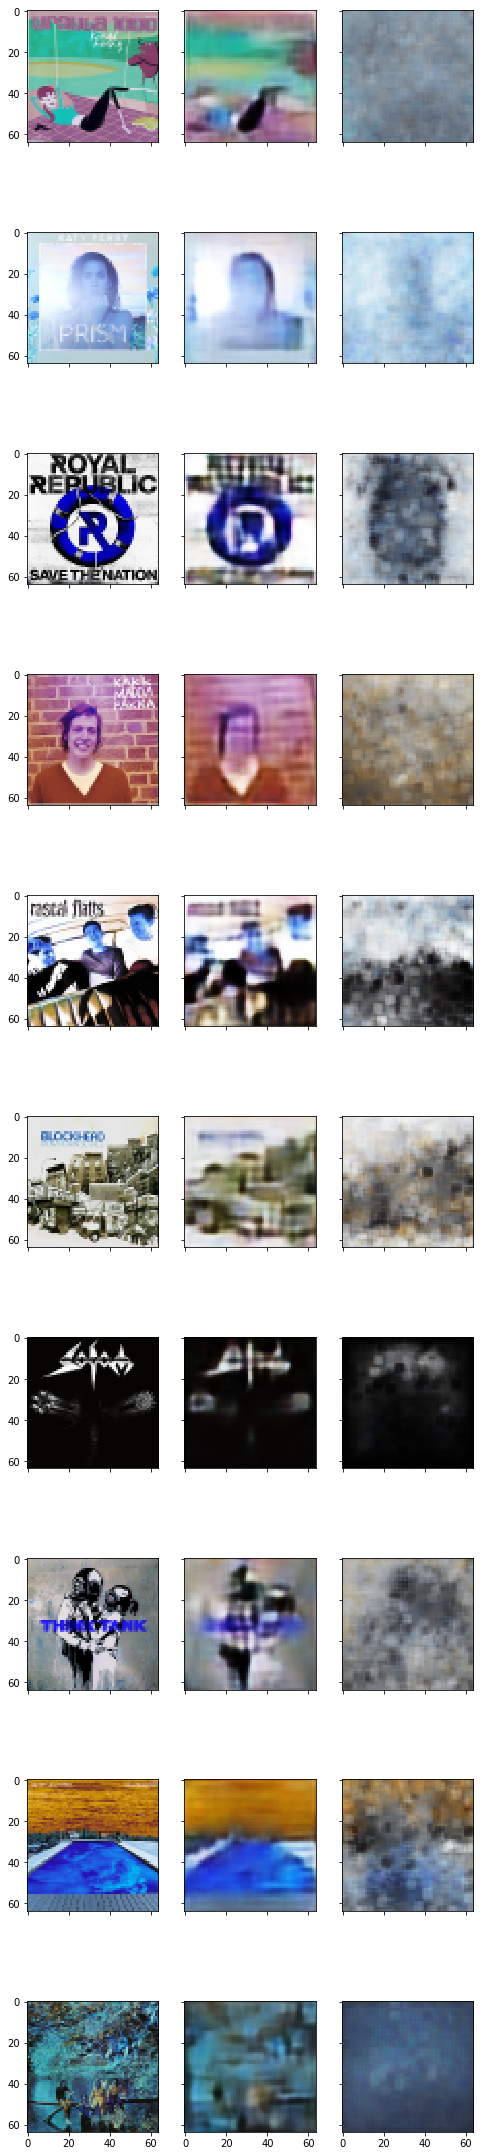

In [13]:
from skimage.io import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 10
start_index = 4000
end_index = start_index + n_samples

pred_set = np.array([x_train[i] for i in range(start_index,start_index+n_samples)])
#pred_set = x_train[start_index:start_index+end_index,:,:,:]
out_vae = vae.predict(pred_set)
out_ae = ae.predict(pred_set)

print(x_train[0].shape)
print(pred_set.shape)
fig_size = (8,40)
print("   Original ===  AE ===  VAE")

f, axarr = plt.subplots(end_index-start_index, 3, figsize=fig_size)

for i in range(n_samples):
    axarr[i,0].imshow(pred_set[i])
    axarr[i,1].imshow(out_ae[i])
    axarr[i,2].imshow(out_vae[i])
    for ax in axarr.flat:
        ax.label_outer()
plt.show()